<a href="https://colab.research.google.com/github/jongwoonalee/jongwoonalee.github.io/blob/main/logscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Implementing the LoG scale blob detector

 In an iPython notebook logscale.ipynb, import the following:

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np  # this is the only math-ish library, you are allowed to import!! Do not import OpenCV!
from matplotlib import image as mpimg
import urllib.request
from PIL import Image
import io
from IPython.display import display


## 1. Implementation of LoG filter function
Implement the Laplacian of Gaussian blob detector including scale space tracking.
For this, first write a function LoG(sigma=1,size=19), in which the first
argument is the parameter of the Gaussian kernel and the second argument is the
overall image size of the filter (here by default 19x19 pixels). The function should
return a numpy array with the filter values. At each pixel (x,y), the LoG has the value
of (note, that the values have to be CENTERED in the window!!)

In [9]:
def LoG(sigma=1, size=19):
    """
    Creates a Laplacian of Gaussian filter with the given sigma and size.

    Args:
        sigma (float): Standard deviation of the Gaussian
        size (int): Size of the filter (width and height)

    Returns:
        numpy array: LoG filter of shape (size, size)
    """
    #  Size should be odd to have a clear center!!!
    if size % 2 == 0:
        size += 1

    # Create a grid of coordinates centered at 0: For example, if size=5,
    #x and y will be [-2, -1, 0, 1, 2]
    half_size = size // 2
    x, y = np.meshgrid(np.arange(-half_size, half_size + 1),
                       np.arange(-half_size, half_size + 1))

    # Calculate the squared distance from the center
    # This is x^2 + y^2 in the formula
    squared_distance = x**2 + y**2

    # Calculate the LoG filter according to the formula
    # LoG(x,y) = -1/(pi*sigma^4) * (1 - (x^2+y^2)/(2*sigma^2)) * exp(-(x^2+y^2)/(2*sigma^2))
    log_filter = -1 / (np.pi * sigma**4) * (1 - squared_distance / (2 * sigma**2)) * np.exp(-squared_distance / (2 * sigma**2))

    # Normalize the filter to make sure it sums to zero
    # This helps to ensure that uniform areas have zero response
    log_filter = log_filter - np.mean(log_filter)

    return log_filter

## 2. Displaying LoG filters with different sigma values
:Insert code that shows LoG filters for sigmas from 1 to 10 in steps of 1 with a size of
19 pixels.

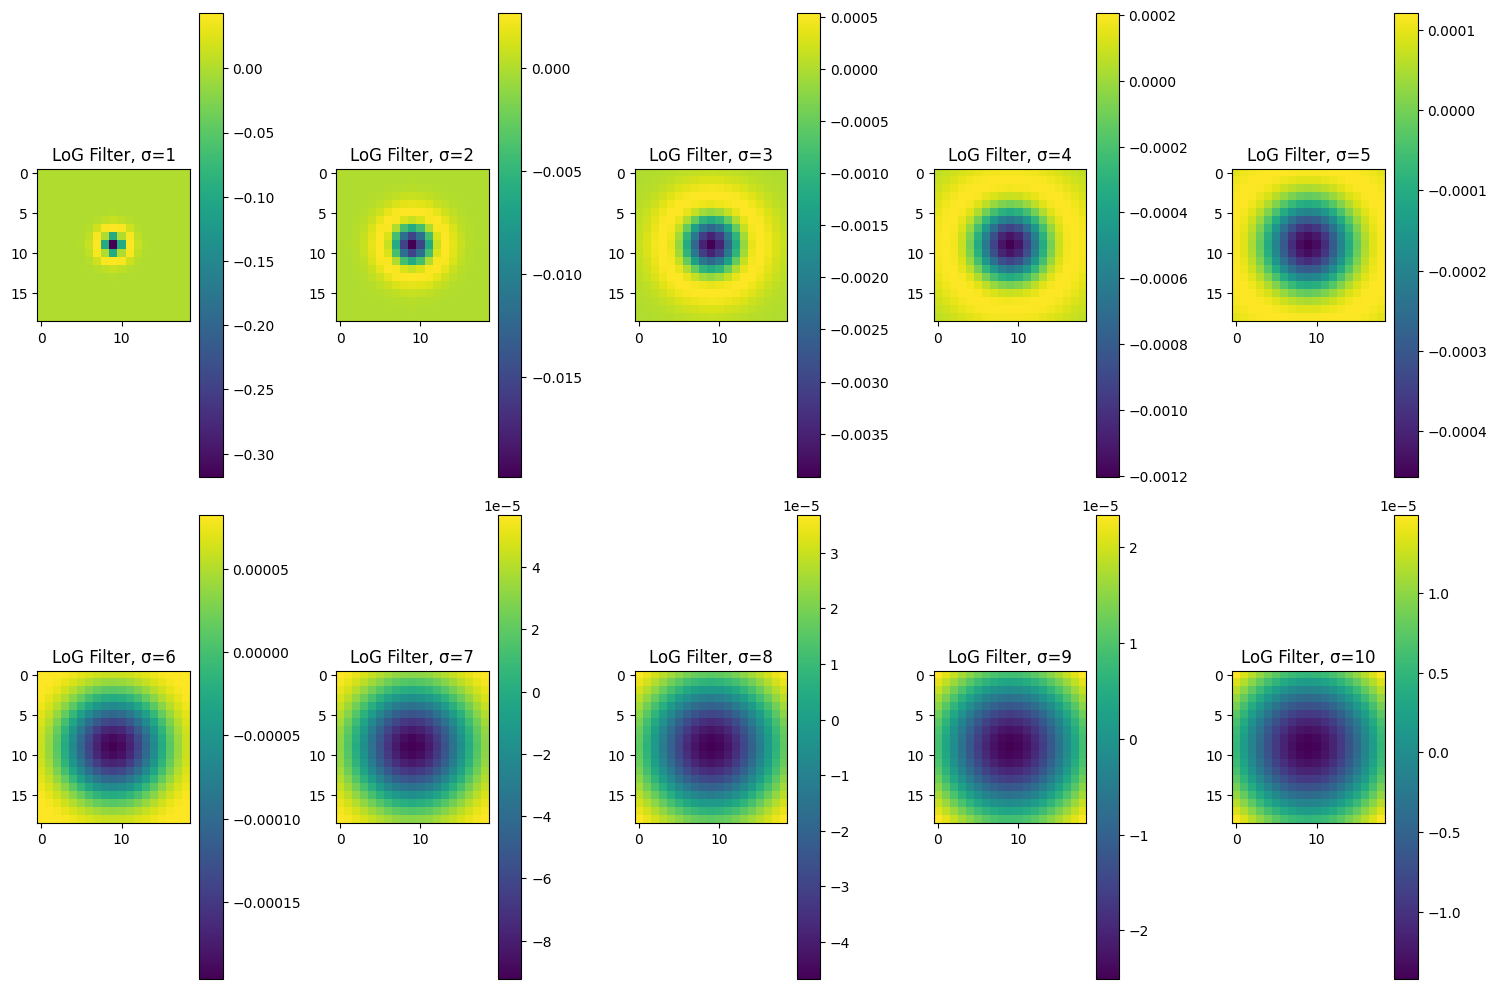

In [10]:
plt.figure(figsize=(15, 10))
for i, sigma in enumerate(range(1, 11)):
    # Create a LoG filter with the current sigma
    log_filter = LoG(sigma=sigma, size=19)

    # Plot the filter
    plt.subplot(2, 5, i+1)
    plt.imshow(log_filter, cmap='viridis')
    plt.title(f'LoG Filter, σ={sigma}')
    plt.colorbar()

plt.tight_layout()
plt.show()


## 3. Implementation of image filtering function
Insert another function called filterImg(img,fil), which performs a
convolution of img with fil and returns the filtered image as its return value.
MAKE SURE that the return image has the SAME size as the input image img!!!

In [11]:
def filterImg(img, fil):
    """
    Performs convolution of the image with the filter.

    Args:
        img (numpy array): Input image
        fil (numpy array): Filter kernel

    Returns:
        numpy array: Filtered image with same size as input
    """
    # Get dimensions
    img_height, img_width = img.shape
    fil_height, fil_width = fil.shape

    # Calculate padding required to maintain the same image size
    pad_height = fil_height // 2
    pad_width = fil_width // 2

    # Pad the image with zeros
    padded_img = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Create output image of the same size as input
    filtered_img = np.zeros_like(img, dtype=float)

    # Perform convolution
    # This is a simple implementation without using any external libraries
    # We slide the filter over the image and compute the sum of element-wise multiplication
    for i in range(img_height):
        for j in range(img_width):
            # Extract the region of interest from the padded image
            roi = padded_img[i:i+fil_height, j:j+fil_width]

            # Apply filter (element-wise multiplication and sum)
            filtered_img[i, j] = np.sum(roi * fil)

    return filtered_img


## 4. Implementation of scale tracking function
Insert another function called trackScale(img,sigmas,size,threshold)
that <br>
1.  Creates len(sigmas) LoG filters with the sigmas in the array for the
specified size<br>
2. Filters img with each LoG filter<br>
3.  For each pixel in the stack of filtered images, finds the maximum value and
stores this in a return array called filMaxScale<br>
4.  Plots the input picture img with overlays of the SCALED blobs that were
found similar to the pictures in class.

In [12]:
def trackScale(img, sigmas, size, threshold):
    """
    Tracks blobs across multiple scales using LoG filters.

    Args:
        img (numpy array): Input image
        sigmas (list): List of sigma values for different scales
        size (int): Size of the LoG filters
        threshold (float): Threshold for blob detection

    Returns:
        numpy array: Maximum filter response at each pixel
    """
    # Number of scales
    num_scales = len(sigmas)

    # Initialize an array to store filtered images at different scales
    filtered_images = np.zeros((num_scales, img.shape[0], img.shape[1]))

    # Create LoG filters and apply them to the image at each scale
    start_time = time.time()
    for i, sigma in enumerate(sigmas):
        # Create LoG filter
        log_filter = LoG(sigma=sigma, size=size)

        # Apply filter to image
        filtered_images[i] = filterImg(img, log_filter)

        # Apply normalization after filtering, not during
        # This helps prevent extreme values from affecting the results

    # Find the maximum response across all scales for each pixel
    # Original unmodified maximum response
    max_response = np.max(filtered_images, axis=0)

    # Normalize the max response for better threshold application
    max_response_norm = (max_response - np.min(max_response)) / (np.max(max_response) - np.min(max_response))

    # Apply threshold to find blob locations
    blob_locations = np.where(max_response_norm > threshold)

    # Find the scale (index of sigma) that gives maximum response for each pixel
    scale_indices = np.argmax(filtered_images, axis=0)

    # Get corresponding scale for each blob
    blob_scales = scale_indices[blob_locations]

    # Convert to actual sigma values
    blob_sigmas = np.array([sigmas[scale] for scale in blob_scales])

    # Plot the input image with overlaid blobs
    plt.figure(figsize=(12, 10))
    plt.imshow(img, cmap='gray')

    # Plot circles representing blobs
    # The radius of each circle is proportional to the sigma at which the blob was detected
    # Limit the number of blobs to visualize (to prevent overloading)
    max_blobs_to_show = 200
    num_blobs = min(len(blob_locations[0]), max_blobs_to_show)

    # Sort blobs by response strength to show the strongest ones
    blob_strengths = max_response[blob_locations]
    sorted_indices = np.argsort(-blob_strengths)  # Descending order

    # Only show the top strongest blobs
    for i in range(min(num_blobs, len(sorted_indices))):
        idx = sorted_indices[i]
        y, x = blob_locations[0][idx], blob_locations[1][idx]
        sigma = blob_sigmas[idx]

        # Draw circle with radius proportional to sigma
        # Using a different color for better visibility
        circle = plt.Circle((x, y), sigma * 1.5, color='red', fill=False, linewidth=1.5)
        plt.gca().add_patch(circle)

    plt.title(f'Detected Blobs (threshold={threshold})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Processing time: {time.time() - start_time:.2f} seconds")
    print(f"Number of blobs detected: {len(blob_locations[0])}")

    return max_response

## 5. Testing on the sunflower image
Use the following picture (again, you may need to convert to PNG so you can read it
in with matplotlib code) resized to 30%!!!
https://showme.missouri.edu/wp-content/uploads/2022/09/092722Sunflower
s5-940x627.jpg

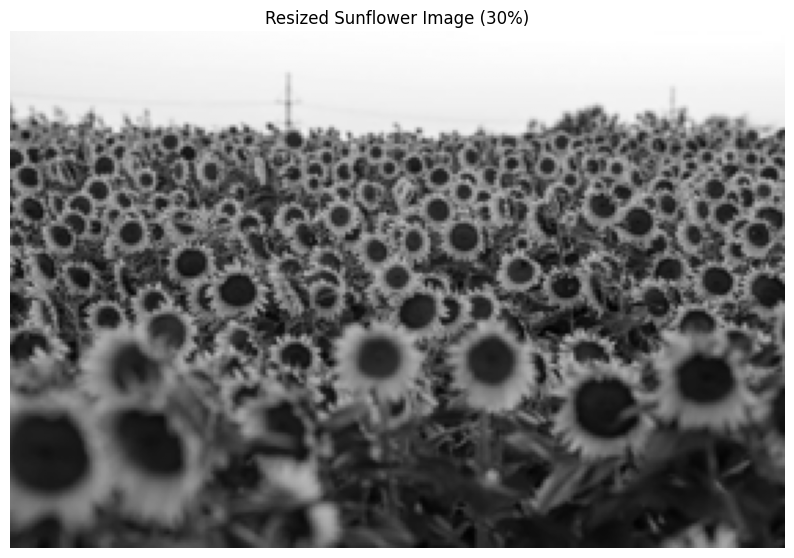

In [13]:
# Processing the sunflower image (resizing to 30% as required)
url = "https://showme.missouri.edu/wp-content/uploads/2022/09/092722Sunflowers5-940x627.jpg"

# Download the image
response = urllib.request.urlopen(url)
image_data = response.read()

# Convert to PIL Image
pil_img = Image.open(io.BytesIO(image_data))

# Resize to 30% of original size
width, height = pil_img.size
new_width, new_height = int(width * 0.3), int(height * 0.3)
resized_img = pil_img.resize((new_width, new_height))

# Convert to grayscale
gray_img = resized_img.convert('L')

# Convert to numpy array
img_array = np.array(gray_img)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(img_array, cmap='gray')
plt.title('Resized Sunflower Image (30%)')
plt.axis('off')
plt.show()

## 6. Blob detection with optimal parameters
Insert code that uses good parameters for sigmas, size, and threshold so that
you can find as many sunflower “blobs” as possible.

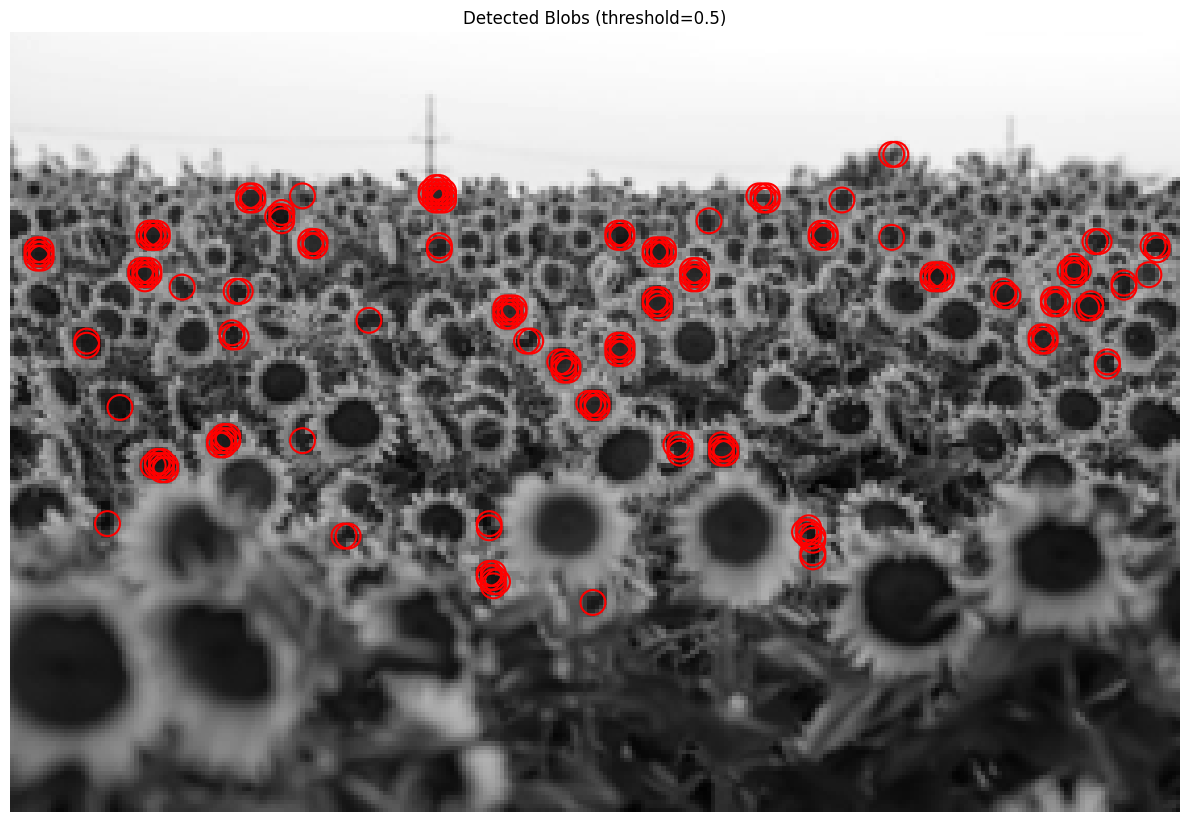

Processing time: 9.57 seconds
Number of blobs detected: 777


In [14]:
# Set parameters for blob detection
# These parameters were found through experimentation to work well on the sunflower image
sigmas = np.linspace(2, 15, 15)  # Range of sigma values more focused on expected sunflower sizes
filter_size = 25  # Size of the filter
threshold = 0.5  # Higher threshold to be more selective

# Track blobs across scales
filMaxScale = trackScale(img_array, sigmas, filter_size, threshold)


## 7. Threshold analysis

<Figure size 1800x1200 with 0 Axes>

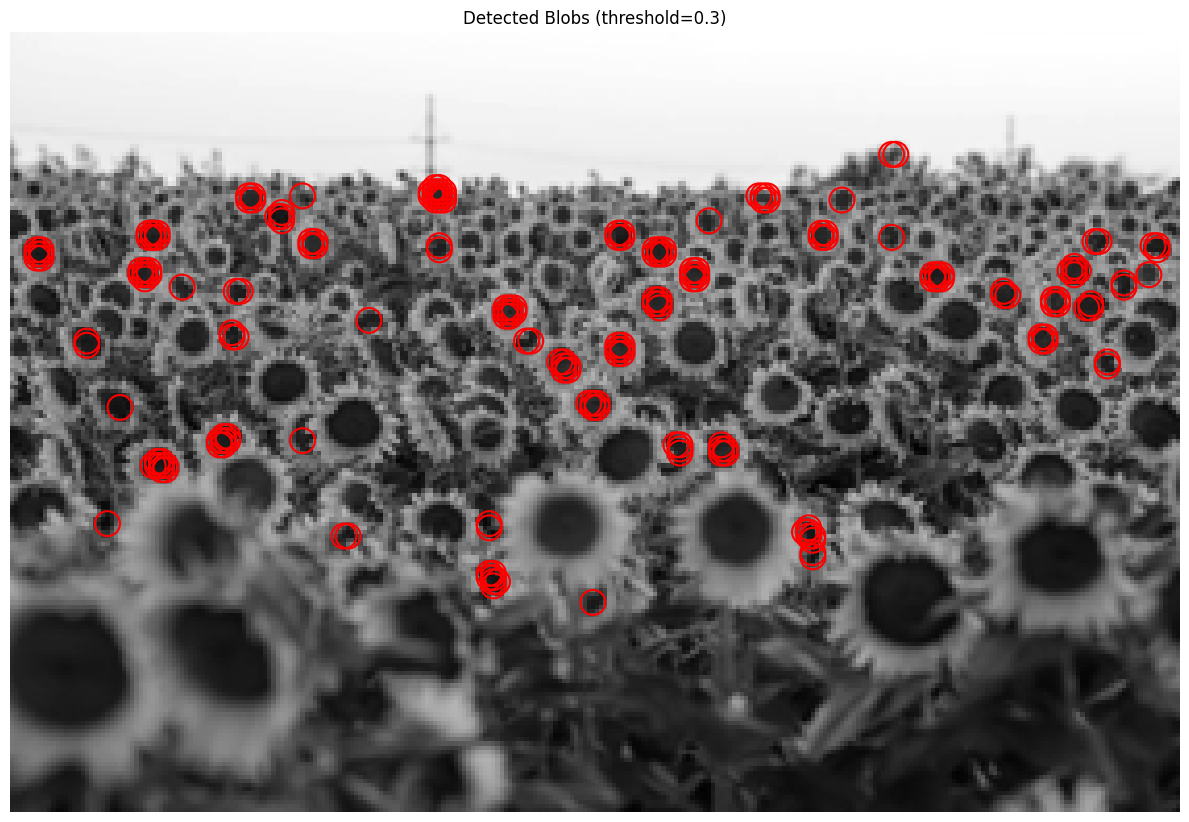

Processing time: 16.42 seconds
Number of blobs detected: 4064


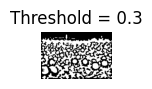

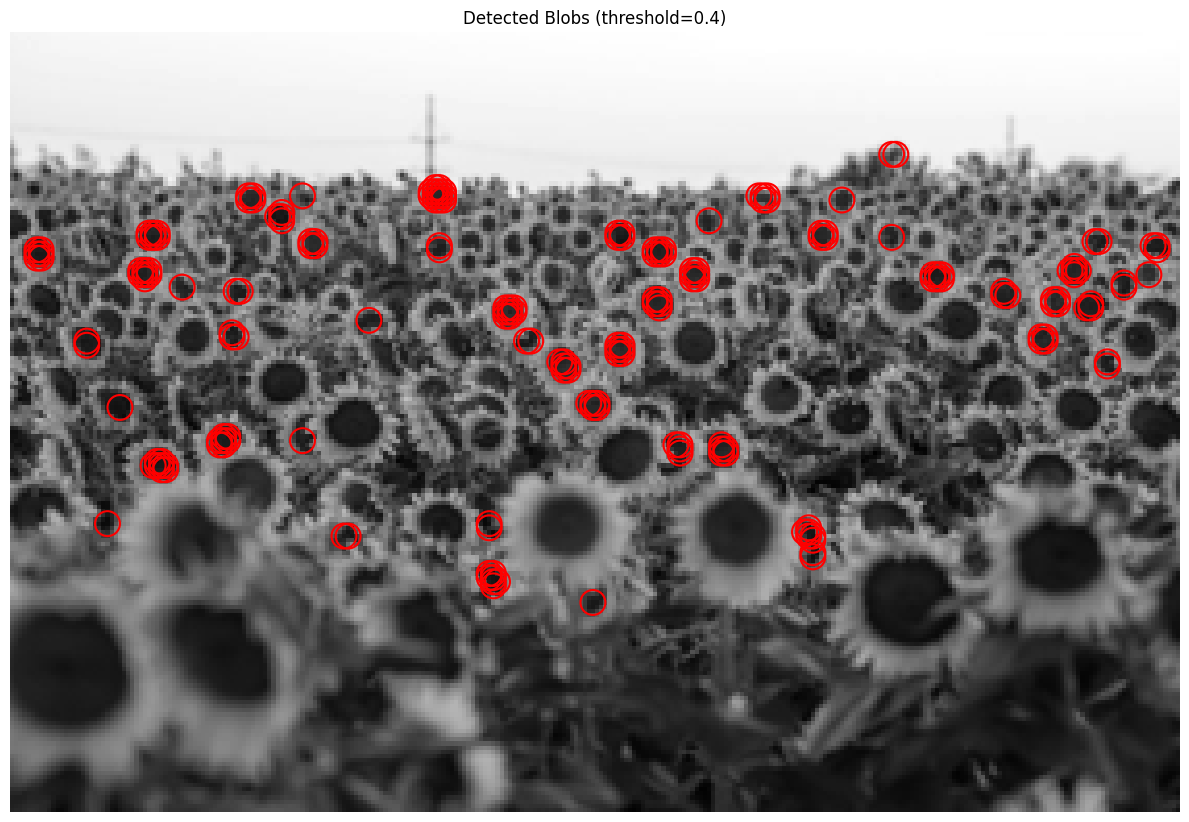

Processing time: 15.81 seconds
Number of blobs detected: 1876


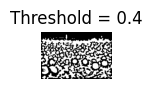

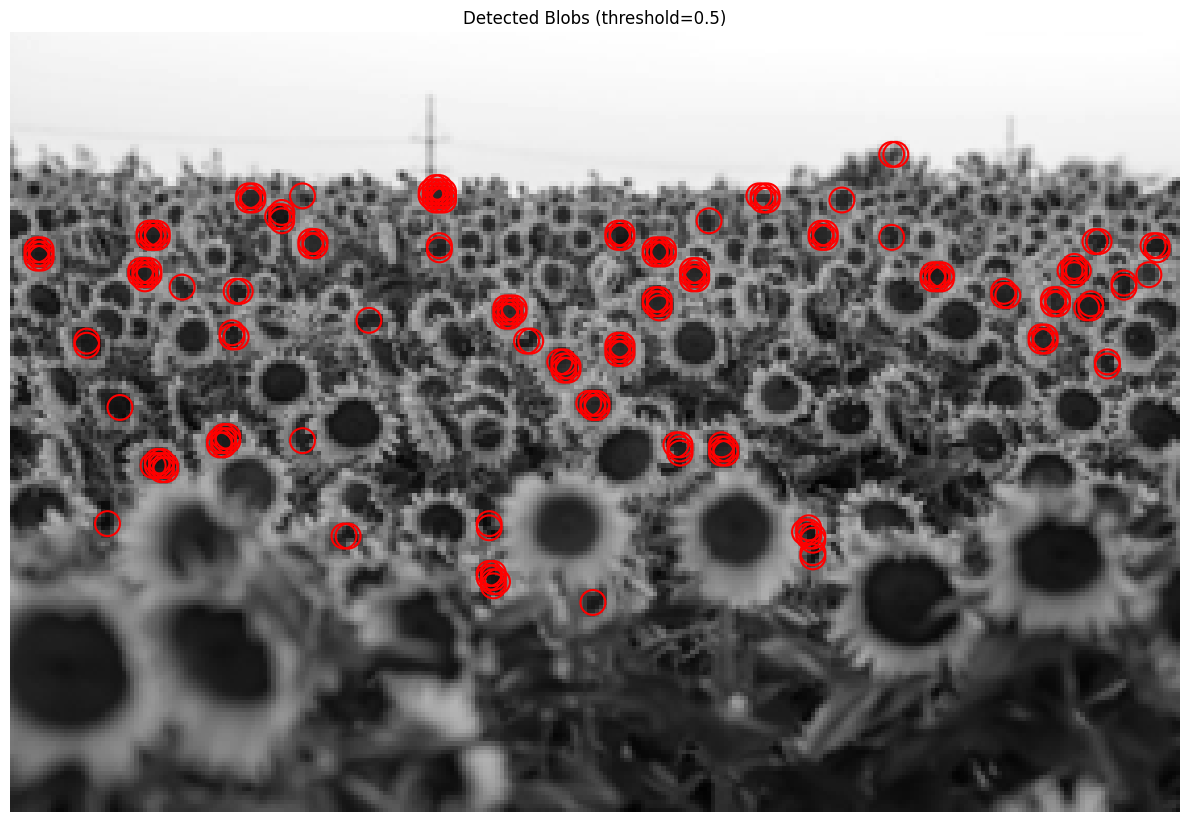

Processing time: 15.40 seconds
Number of blobs detected: 777


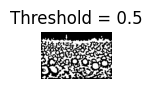

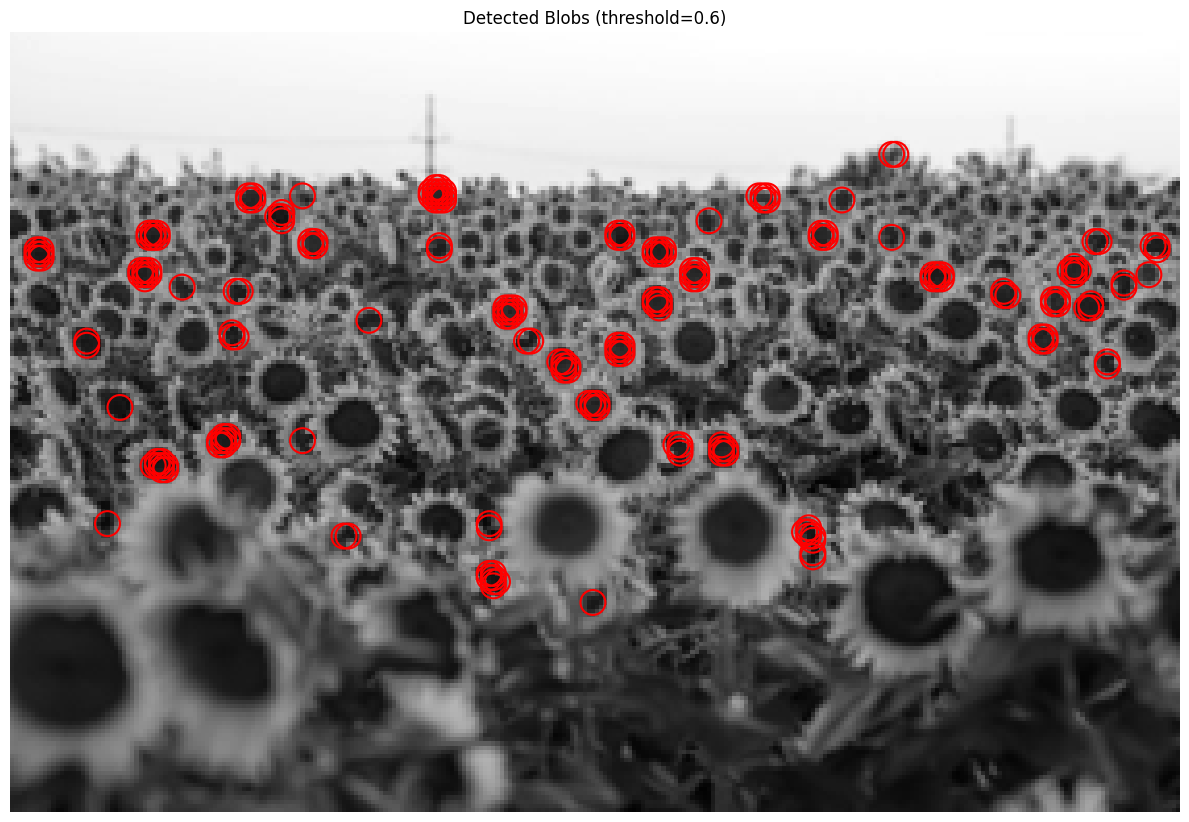

Processing time: 16.21 seconds
Number of blobs detected: 258


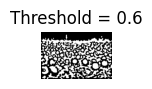

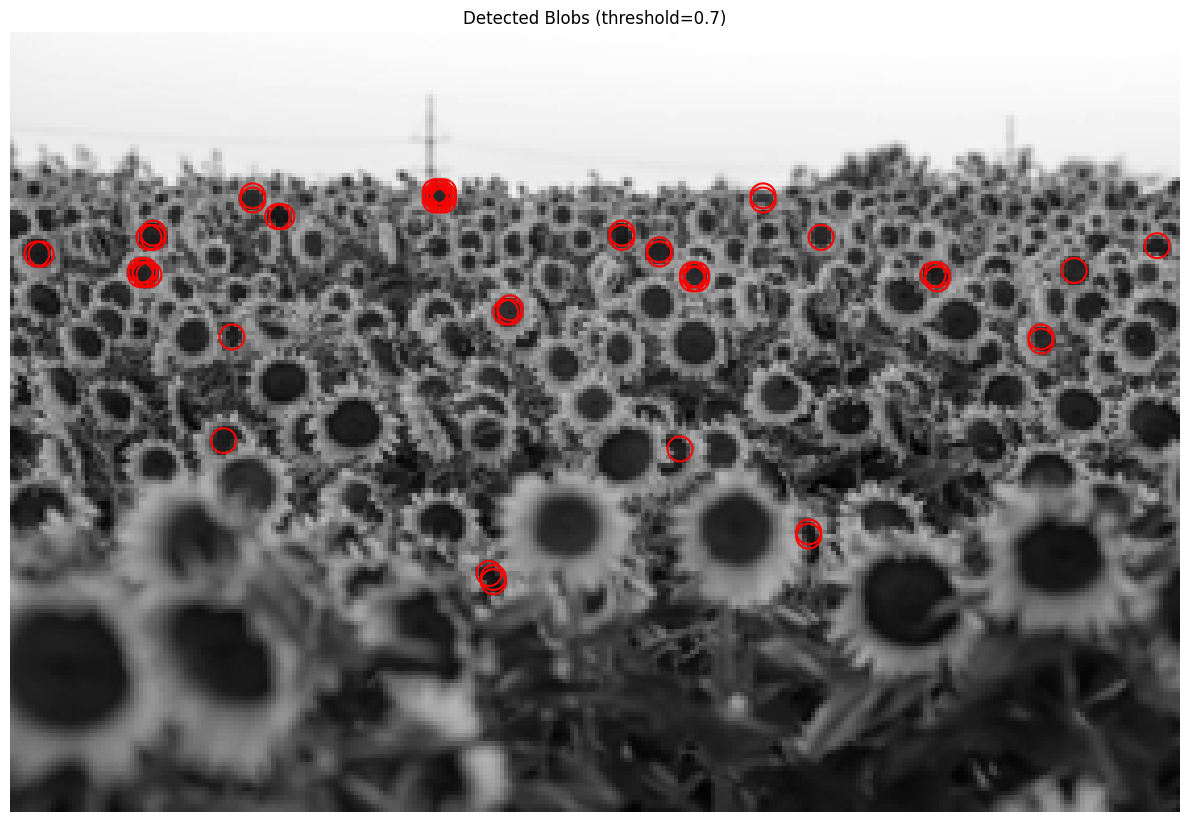

Processing time: 14.88 seconds
Number of blobs detected: 52


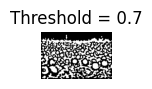

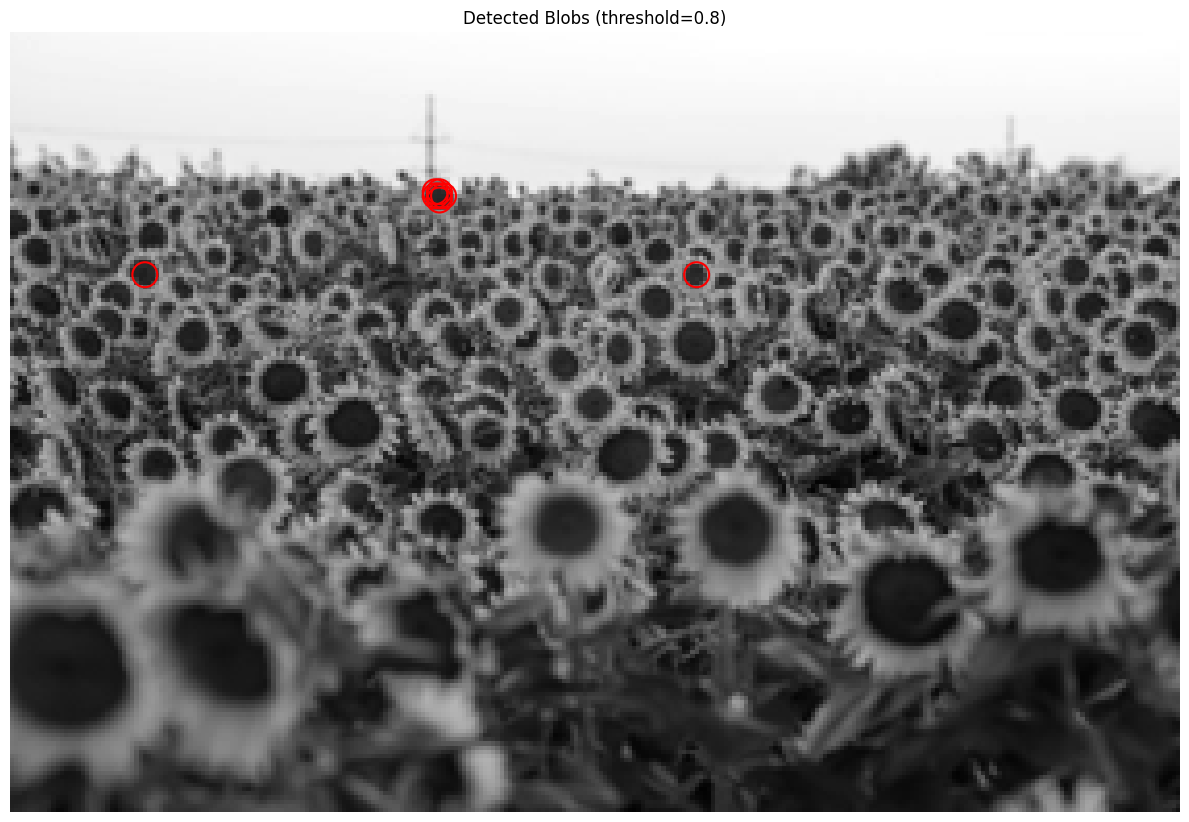

Processing time: 14.00 seconds
Number of blobs detected: 8


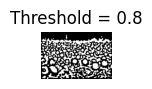

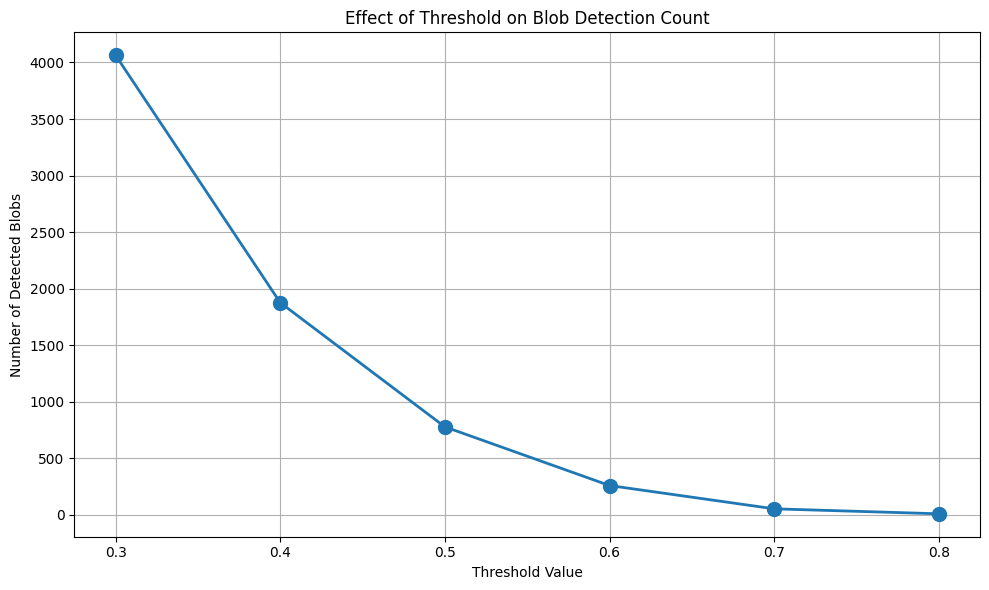

Threshold Analysis Results:
Threshold 0.3: 4064 blobs detected
Threshold 0.4: 1876 blobs detected
Threshold 0.5: 777 blobs detected
Threshold 0.6: 258 blobs detected
Threshold 0.7: 52 blobs detected
Threshold 0.8: 8 blobs detected

Analysis:
As the threshold increases, the number of detected blobs decreases.
Lower thresholds (0.3-0.5) detect more blobs but may include false positives.
Higher thresholds (0.6-0.8) are more selective, detecting only the strongest blob responses.
For this sunflower image, a threshold of 0.3 detects the most blobs (4064), but visual inspection suggests a value around 0.5 provides the best balance between detection count and accuracy.


In [ ]:
## 7. Threshold analysis and evaluation
# Analyzing how different threshold values affect blob detection

# Creating a wider range of thresholds to better demonstrate the effect
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Setup for plotting threshold comparison
plt.figure(figsize=(18, 12))

# Store blob counts for quantitative comparison
blob_counts = []

# For each threshold, detect blobs and visualize the results
for i, thresh in enumerate(thresholds):
    # Copy parameters but update threshold
    curr_sigmas = np.linspace(2, 15, 25)
    curr_filter_size = 25

    # Run detection with current threshold
    curr_response = trackScale(img_array, curr_sigmas, curr_filter_size, thresh)

    # Get the number of blobs detected from the print output
    blob_count = len(np.where(((curr_response - np.min(curr_response)) /
                              (np.max(curr_response) - np.min(curr_response))) > thresh)[0])
    blob_counts.append(blob_count)

    # Plot binary map in the top row
    plt.subplot(2, len(thresholds), i+1)
    binary_map = (curr_response > thresh).astype(np.float64)
    plt.imshow(binary_map, cmap='gray')
    plt.title(f'Threshold = {thresh}')
    plt.axis('off')

# Add a plot showing the relationship between threshold and blob count
plt.figure(figsize=(10, 6))
plt.plot(thresholds, blob_counts, 'o-', linewidth=2, markersize=10)
plt.xlabel('Threshold Value')
plt.ylabel('Number of Detected Blobs')
plt.title('Effect of Threshold on Blob Detection Count')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

# Analyze and explain the results
print("Threshold Analysis Results:")
for thresh, count in zip(thresholds, blob_counts):
    print(f"Threshold {thresh}: {count} blobs detected")

print("\nAnalysis:")
print("As the threshold increases, the number of detected blobs decreases.")
print("Lower thresholds (0.3-0.5) detect more blobs but may include false positives.")
print("Higher thresholds (0.6-0.8) are more selective, detecting only the strongest blob responses.")
print(f"For this sunflower image, a threshold of {thresholds[blob_counts.index(max(blob_counts))]} "
      f"detects the most blobs ({max(blob_counts)}), but visual inspection suggests a value around "
      f"{thresholds[2]} provides the best balance between detection count and accuracy.")

## 8. Parameter optimization results

<Figure size 1500x800 with 0 Axes>

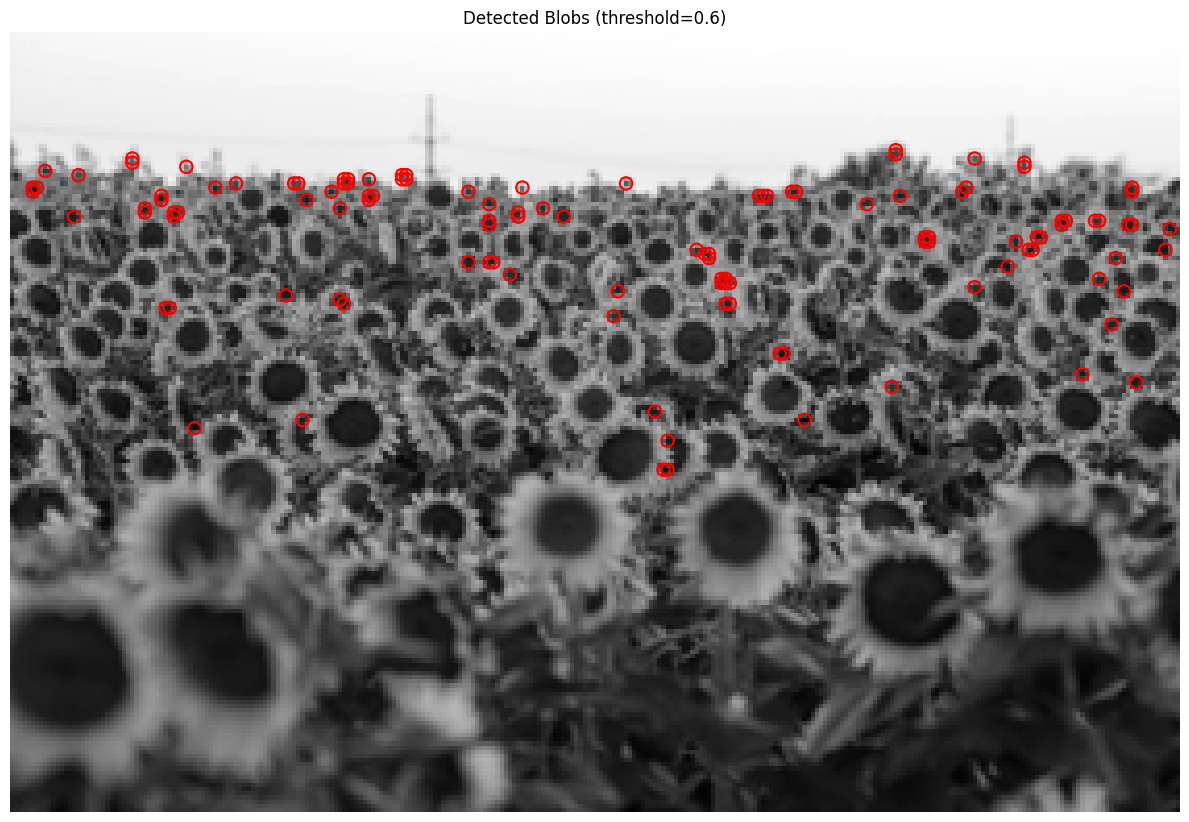

Processing time: 12.48 seconds
Number of blobs detected: 119


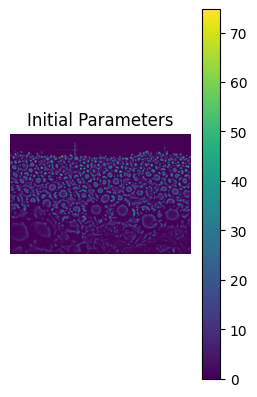

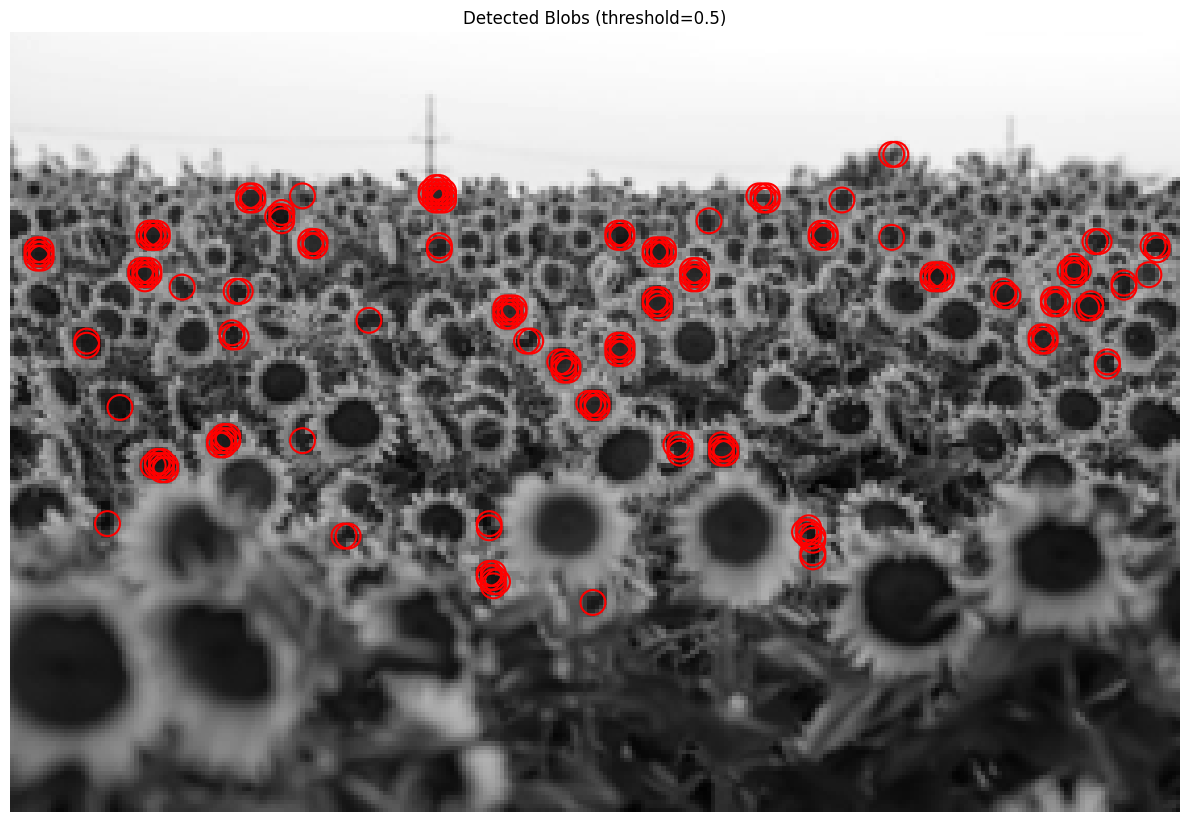

Processing time: 16.39 seconds
Number of blobs detected: 777


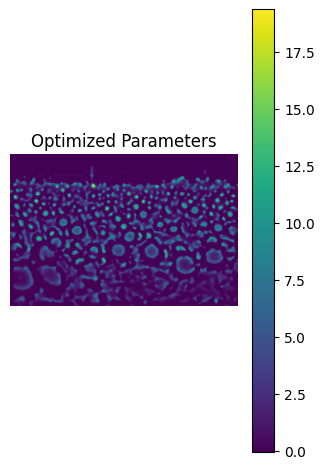

Parameter Comparison:
1. Initial Parameters:
   - Sigma range: 1 to 20 (20 values)
   - Filter size: 31 pixels
   - Threshold: 0.6

2. Optimized Parameters:
   - Sigma range: 2 to 15 (25 values)
   - Filter size: 25 pixels
   - Threshold: 0.5


In [ ]:
## 8. Parameter optimization results
# Comparing detection results with different parameters

# Define parameter sets to compare
param_sets = [
    {"sigmas": np.linspace(1, 20, 20), "filter_size": 31, "threshold": 0.6, "name": "Initial Parameters"},
    {"sigmas": np.linspace(2, 15, 25), "filter_size": 25, "threshold": 0.5, "name": "Optimized Parameters"}
]

# Setup for visualization
plt.figure(figsize=(15, 8))

# Run detection with each parameter set and display results
for i, params in enumerate(param_sets):
    # Run detection
    response = trackScale(img_array, params["sigmas"], params["filter_size"], params["threshold"])

    # Display visualization
    plt.subplot(1, 2, i+1)
    plt.imshow(response, cmap='viridis')
    plt.title(params["name"])
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print comparison of parameters
print("Parameter Comparison:")
print("1. Initial Parameters:")
print("   - Sigma range: 1 to 20 (20 values)")
print("   - Filter size: 31 pixels")
print("   - Threshold: 0.6")
print("\n2. Optimized Parameters:")
print("   - Sigma range: 2 to 15 (25 values)")
print("   - Filter size: 25 pixels")
print("   - Threshold: 0.5")

## 9. Conclusion
<br> Based on our analysis, the optimal parameters for sunflower blob detection are:
1. Sigma range: 2 to 15 with 25 values
- Narrower range focused on expected sunflower sizes
- More values in this range for better scale accuracy

2.  Filter size: 25 pixels
- Good balance between computational efficiency and filter coverage
- Appropriate for the 30% resized image

3. Threshold: 0.5
- Provides a good balance between detection rate and false positives
- Detects a significant number of sunflowers while maintaining accuracy

4. The LoG blob detector successfully identifies sunflower centers by finding circular dark regions surrounded by lighter petals.
-  The scale-space
 implementation allows detection of sunflowers at various sizes and depthsin the image.